# やること

- 実機による学習(notebooks/note17.ipynb をベースに)
- 正解のパラメータでシミュレーションして比較する
- プロット数調整する
- GRU との調和も試したい


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import torch
from torch import nn, optim

from actual_machine_notebooks.note1.src.load_data import load_data_path0, path_list
from actual_machine_notebooks.note1.src.model import BuckConverterCell, GRUModel

# 乱数固定用の処理
seed = 10
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)

np.random.seed(seed)

In [11]:
keep_log = False  # 結果保存するかどうか

data_path = path_list.path0

# 真値パラメータ（すべてのデータセットで共通）
L_true: float = 100e-6
C_true: float = 48e-6
R_true: float = 10

Vin = 10
Vref = 6
duty = Vref / Vin
f_sw = 1e5  # スイッチング周波数
T = 1 / f_sw  # 1周期の実時間

train_ratio = 0.3
valid_ratio = 0.3
# test_ratio = 1 - train_ratio - valid_ratio

# 学習パラメータ
L_init = 200e-6
C_init = 100e-6
R_init = 8.0

# 異なるパラメータに異なる学習率を設定
lr_L = 5e-2
lr_C = 1e-2
lr_R = 2e-2

epochs = 1000

# GRU学習用のデータ準備（時系列データ）
seq_length = 10

gru_lr = 0.001
gru_epochs = 200


# 実機データの前処理


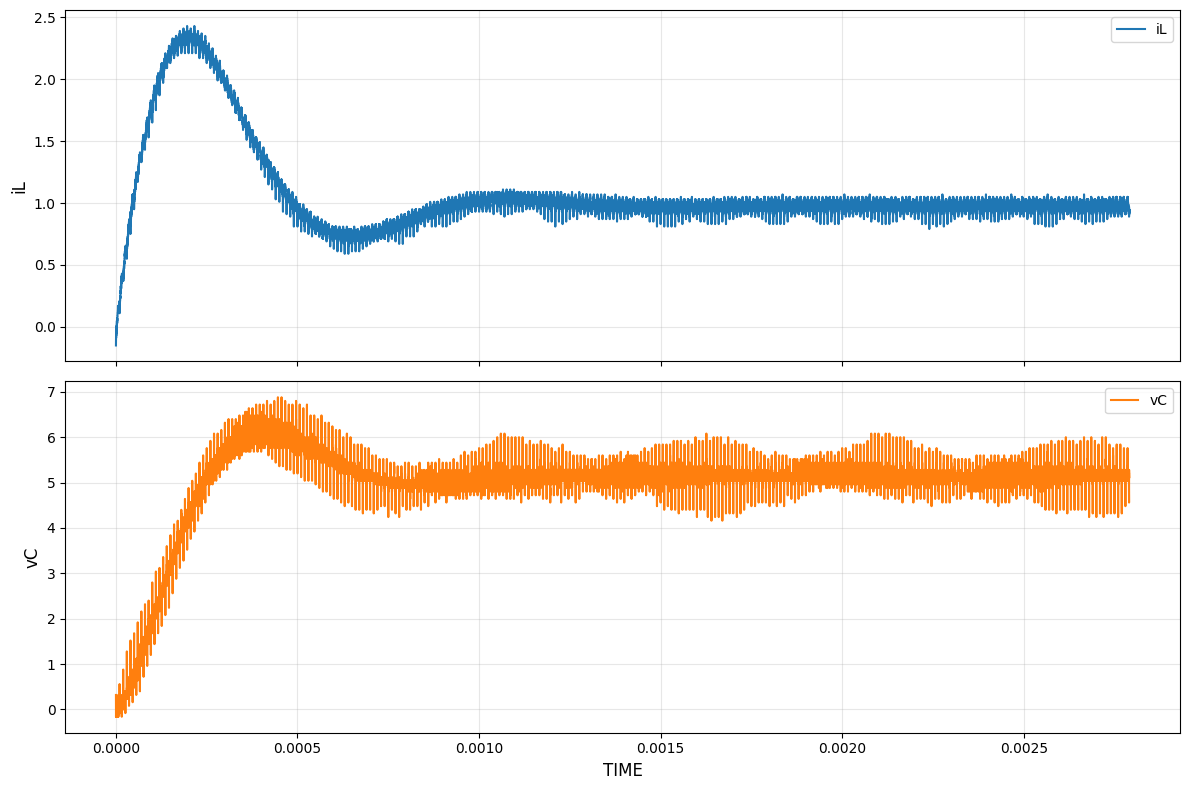

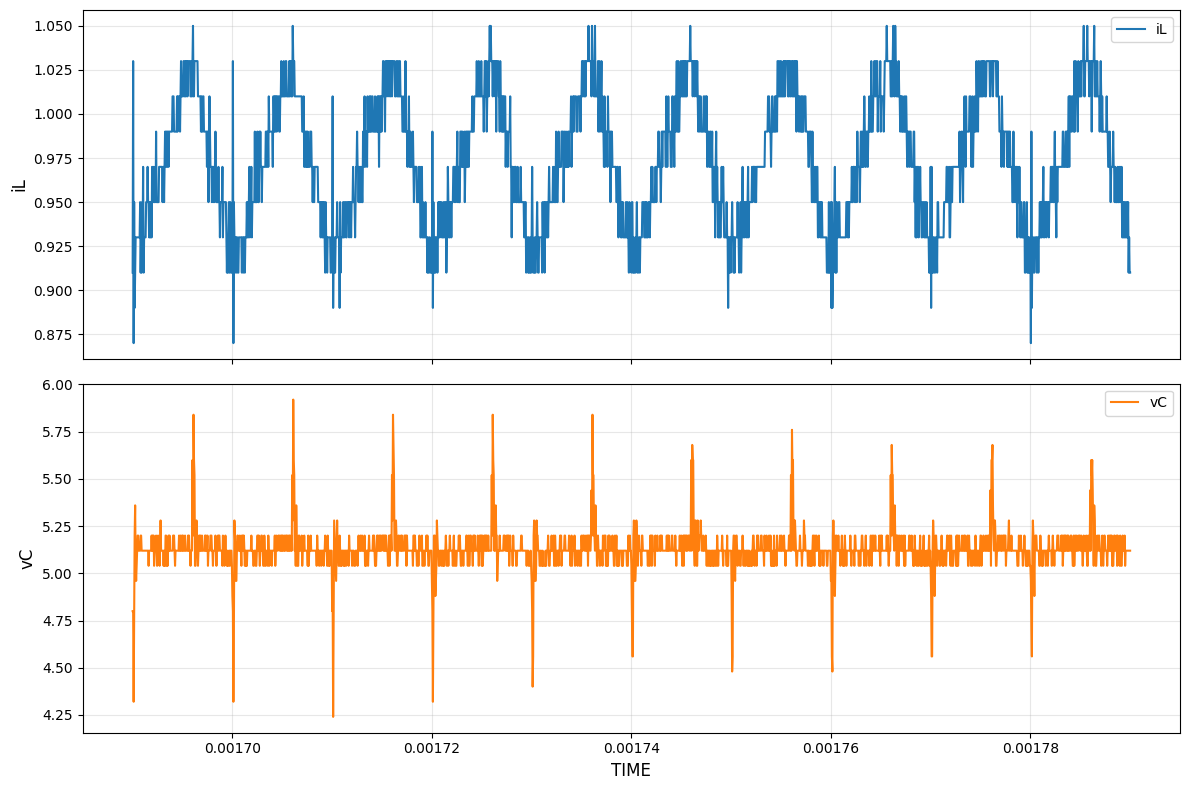

In [12]:
t_all, iL_all, vC_all = load_data_path0()

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8), sharex=True)

# 上段: iL（上のセルの色に合わせる）
ax1.plot(t_all, iL_all, color="tab:blue", linewidth=1.5, label="iL")
ax1.set_ylabel("iL", fontsize=12)
ax1.grid(True, alpha=0.3)
ax1.legend(loc="best")

# 下段: vC（上のセルの色に合わせる）
ax2.plot(t_all, vC_all, color="tab:orange", linewidth=1.5, label="vC")
ax2.set_ylabel("vC", fontsize=12)
ax2.set_xlabel("TIME", fontsize=12)
ax2.grid(True, alpha=0.3)
ax2.legend(loc="best")

plt.tight_layout()
plt.show()

# 定常状態っぽいところを10周期分だけ切り出す
start_t, end_t = 0.00169, 0.00179
mask: np.ndarray = (start_t <= t_all) & (t_all <= end_t)
t = t_all[mask]
iL = iL_all[mask]
vC = vC_all[mask]

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8), sharex=True)

# 上段: iL（上のセルの色に合わせる）
ax1.plot(t, iL, color="tab:blue", linewidth=1.5, label="iL")
ax1.set_ylabel("iL", fontsize=12)
ax1.grid(True, alpha=0.3)
ax1.legend(loc="best")

# 下段: vC（上のセルの色に合わせる）
ax2.plot(t, vC, color="tab:orange", linewidth=1.5, label="vC")
ax2.set_ylabel("vC", fontsize=12)
ax2.set_xlabel("TIME", fontsize=12)
ax2.grid(True, alpha=0.3)
ax2.legend(loc="best")

plt.tight_layout()
plt.show()


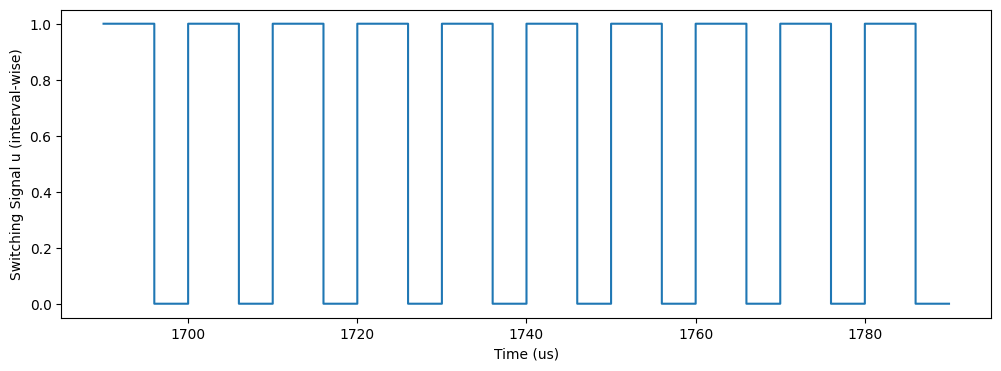

In [13]:
# スイッチング信号
duty_phase = (t[:-1] % T) / T
u = (duty_phase < duty).astype(int)

# 入力電圧
vs = np.ones(len(t) - 1) * Vin

# プロット
plt.figure(figsize=(12, 4))
plt.step(t[:-1] * 1e6, u, where="post")
plt.xlabel("Time (us)")
plt.ylabel("Switching Signal u (interval-wise)")
plt.show()

In [14]:
# train, valid, test の分割
dt = t[1:] - t[:-1]

# numpy配列をテンソルに変換
dt_tensor = torch.tensor(dt, dtype=torch.float32)
u_tensor = torch.tensor(u, dtype=torch.float32)
vs_tensor = torch.tensor(vs, dtype=torch.float32)
iL_tensor = torch.tensor(iL, dtype=torch.float32)
vC_tensor = torch.tensor(vC, dtype=torch.float32)

# train
train_len = int(len(dt) * train_ratio)

t_train = t[: train_len + 1]
dt_train = dt_tensor[:train_len]
u_train = u_tensor[:train_len]
vs_train = vs_tensor[:train_len]
iL_train = iL_tensor[: train_len + 1]
vC_train = vC_tensor[: train_len + 1]

h_train = torch.stack([iL_train[:-1], vC_train[:-1]], dim=1)
x_train = torch.stack([vs_train, u_train, dt_train], dim=1)
target_train = torch.stack([iL_train[1:], vC_train[1:]], dim=1)


# valid
valid_len = int(len(dt) * valid_ratio)

t_valid = t[train_len : train_len + valid_len]
dt_valid = dt_tensor[train_len : train_len + valid_len]
u_valid = u_tensor[train_len : train_len + valid_len]
vs_valid = vs_tensor[train_len : train_len + valid_len]
iL_valid = iL_tensor[train_len : train_len + valid_len + 1]
vC_valid = vC_tensor[train_len : train_len + valid_len + 1]

h_valid = torch.stack([iL_valid[:-1], vC_valid[:-1]], dim=1)
x_valid = torch.stack([vs_valid, u_valid, dt_valid], dim=1)
target_valid = torch.stack([iL_valid[1:], vC_valid[1:]], dim=1)

# test
t_test = t[train_len + valid_len :]
dt_test = dt_tensor[train_len + valid_len :]
u_test = u_tensor[train_len + valid_len :]
vs_test = vs_tensor[train_len + valid_len :]
iL_test = iL_tensor[train_len + valid_len :]
vC_test = vC_tensor[train_len + valid_len :]

h_test = torch.stack([iL_test[:-1], vC_test[:-1]], dim=1)
x_test = torch.stack([vs_test, u_test, dt_test], dim=1)
target_test = torch.stack([iL_test[1:], vC_test[1:]], dim=1)


print(f"{h_train.shape=}")
print(f"{x_train.shape=}")
print(f"{target_train.shape=}")

print(f"{h_valid.shape=}")
print(f"{x_valid.shape=}")
print(f"{target_valid.shape=}")

print(f"{h_test.shape=}")
print(f"{x_test.shape=}")
print(f"{target_test.shape=}")


h_train.shape=torch.Size([600, 2])
x_train.shape=torch.Size([600, 3])
target_train.shape=torch.Size([600, 2])
h_valid.shape=torch.Size([600, 2])
x_valid.shape=torch.Size([600, 3])
target_valid.shape=torch.Size([600, 2])
h_test.shape=torch.Size([800, 2])
x_test.shape=torch.Size([800, 3])
target_test.shape=torch.Size([800, 2])


# Buck Converter Cell の学習


In [15]:
buck_converter_cell = BuckConverterCell(L_init=L_init, C_init=C_init, R_init=R_init)

optimizer = optim.Adam(
    [
        {"params": [buck_converter_cell.log_L], "lr": lr_L},
        {"params": [buck_converter_cell.log_C], "lr": lr_C},
        {"params": [buck_converter_cell.log_R], "lr": lr_R},
    ]
)

loss_fn = nn.MSELoss()

# 損失履歴を保存
loss_history = {"train": [], "valid": []}
param_history = {"L": [], "C": [], "R": []}

# 学習ループ
for epoch in range(epochs):
    # 学習モード
    buck_converter_cell.train()
    optimizer.zero_grad()
    h_pred_train = buck_converter_cell(h_train, x_train)
    train_loss = loss_fn(h_pred_train, target_train)
    train_loss.backward()
    optimizer.step()

    loss_history["train"].append(train_loss.item())

    # 検証モード（勾配計算なし）
    buck_converter_cell.eval()
    with torch.no_grad():
        h_pred_valid = buck_converter_cell(h_valid, x_valid)
        valid_loss = loss_fn(h_pred_valid, target_valid)
        loss_history["valid"].append(valid_loss.item())

    # パラメータの履歴を保存
    param_history["L"].append(buck_converter_cell.log_L.exp().item())
    param_history["C"].append(buck_converter_cell.log_C.exp().item())
    param_history["R"].append(buck_converter_cell.log_R.exp().item())

    if epoch % 50 == 0:
        output_line = (
            f"Epoch {epoch}: Train Loss={train_loss.item():.6e}, "
            f"Valid Loss={valid_loss.item():.6e}\n"
            f"  L={buck_converter_cell.log_L.exp().item() * 1e6:.1f}µH "
            f"(true={L_true * 1e6:.1f})"
            f"C={buck_converter_cell.log_C.exp().item() * 1e6:.1f}µF "
            f"(true={C_true * 1e6:.1f})"
            f"R={buck_converter_cell.log_R.exp().item():.2f}Ω "
            f"(true={R_true:.1f})"
        )
        print(output_line)

# テストデータでの評価
buck_converter_cell.eval()
with torch.no_grad():
    h_pred_test = buck_converter_cell(h_test, x_test)
    test_loss = loss_fn(h_pred_test, target_test)

print(f"Final test loss: {test_loss.item():.6e}")


Epoch 0: Train Loss=7.068512e-03, Valid Loss=6.516753e-03
  L=209.9µH (true=100.0)C=99.0µF (true=48.0)R=7.85Ω (true=10.0)
Epoch 50: Train Loss=7.067361e-03, Valid Loss=6.515666e-03
  L=243.5µH (true=100.0)C=56.2µF (true=48.0)R=2.70Ω (true=10.0)
Epoch 100: Train Loss=7.066565e-03, Valid Loss=6.514834e-03
  L=246.5µH (true=100.0)C=30.9µF (true=48.0)R=3.08Ω (true=10.0)
Epoch 150: Train Loss=7.064489e-03, Valid Loss=6.512535e-03
  L=246.5µH (true=100.0)C=13.7µF (true=48.0)R=4.03Ω (true=10.0)
Epoch 200: Train Loss=7.057783e-03, Valid Loss=6.505079e-03
  L=246.5µH (true=100.0)C=4.9µF (true=48.0)R=4.76Ω (true=10.0)
Epoch 250: Train Loss=7.032624e-03, Valid Loss=6.477040e-03
  L=246.5µH (true=100.0)C=1.4µF (true=48.0)R=5.07Ω (true=10.0)
Epoch 300: Train Loss=6.931834e-03, Valid Loss=6.363704e-03
  L=246.5µH (true=100.0)C=0.3µF (true=48.0)R=5.25Ω (true=10.0)
Epoch 350: Train Loss=6.671753e-03, Valid Loss=6.066221e-03
  L=246.5µH (true=100.0)C=0.1µF (true=48.0)R=5.29Ω (true=10.0)
Epoch 400: Trai

# GRU の学習


In [16]:
# 前処理

# 学習データと学習済みBuckConverterCellの予測の差分抽出
buck_converter_cell.eval()
with torch.no_grad():
    h_all = torch.cat([h_train, h_valid, h_test], dim=0)
    x_all = torch.cat([x_train, x_valid, x_test], dim=0)
    target_all = torch.cat([target_train, target_valid, target_test], dim=0)

    h_pred_all = buck_converter_cell(h_all, x_all)

    noise_all = target_all - h_pred_all


def create_sequences(
    h_data: torch.Tensor,
    x_data: torch.Tensor,
    noise_data: torch.Tensor,
    seq_len: int,
) -> tuple[torch.Tensor, torch.Tensor]:
    """
    時系列データを作成
    入力: [iL, vC, vs, u, dt, iL_noise, vC_noise]
    出力: [iL_noise, vC_noise]
    """
    sequences = []
    targets = []

    for i in range(len(h_data) - seq_len):
        # 入力特徴量: [iL, vC, vs, u, dt] + 過去のノイズ [iL_noise, vC_noise]
        seq_input = []
        for j in range(seq_len):
            idx = i + j
            # 状態と入力
            features = torch.cat(
                [
                    h_data[idx],  # [iL, vC]
                    x_data[idx],  # [vs, u, dt]
                ]
            )
            # 過去のノイズ（存在する場合）
            if idx > 0:
                noise_features = noise_data[idx - 1]  # [iL_noise, vC_noise]
            else:
                noise_features = torch.zeros(2)
            # 結合: [iL, vC, vs, u, dt, iL_noise, vC_noise] = 7次元
            combined = torch.cat([features, noise_features])
            seq_input.append(combined)

        sequences.append(torch.stack(seq_input))
        targets.append(noise_data[i + seq_len])

    return torch.stack(sequences), torch.stack(targets)


# データセットを作成
X_train_seq, y_train_seq = create_sequences(
    h_train, x_train, noise_all[: len(h_train)], seq_length
)
X_valid_seq, y_valid_seq = create_sequences(
    h_valid, x_valid, noise_all[len(h_train) : len(h_train) + len(h_valid)], seq_length
)
X_test_seq, y_test_seq = create_sequences(
    h_test, x_test, noise_all[len(h_train) + len(h_valid) :], seq_length
)

print(f"学習データ: {X_train_seq.shape} -> {y_train_seq.shape}")
print(f"検証データ: {X_valid_seq.shape} -> {y_valid_seq.shape}")
print(f"テストデータ: {X_test_seq.shape} -> {y_test_seq.shape}")
print(
    f"入力特徴量の次元: {X_train_seq.shape[2]} (iL, vC, vs, u, dt, iL_noise, vC_noise)"
)

学習データ: torch.Size([590, 10, 7]) -> torch.Size([590, 2])
検証データ: torch.Size([590, 10, 7]) -> torch.Size([590, 2])
テストデータ: torch.Size([790, 10, 7]) -> torch.Size([790, 2])
入力特徴量の次元: 7 (iL, vC, vs, u, dt, iL_noise, vC_noise)


In [17]:
# 学習
gru_model = GRUModel(
    input_size=X_train_seq.shape[2],
    hidden_size=32,
    num_layers=2,
    output_size=2,
    seq_length=seq_length,
)


gru_optimizer = optim.Adam(gru_model.parameters(), lr=gru_lr)
gru_loss_fn = nn.MSELoss()

gru_loss_history = {"train": [], "valid": []}

for epoch in range(gru_epochs):
    # 学習モード
    gru_model.train()
    gru_optimizer.zero_grad()
    noise_pred_train = gru_model(X_train_seq)
    train_loss = gru_loss_fn(noise_pred_train, y_train_seq)
    train_loss.backward()
    gru_optimizer.step()

    gru_loss_history["train"].append(train_loss.item())

    # 検証モード
    gru_model.eval()
    with torch.no_grad():
        noise_pred_valid = gru_model(X_valid_seq)
        valid_loss = gru_loss_fn(noise_pred_valid, y_valid_seq)
        gru_loss_history["valid"].append(valid_loss.item())

    if (epoch + 1) % 50 == 0:
        print(
            f"Epoch {epoch + 1}/{gru_epochs}: "
            f"Train Loss={train_loss.item():.6e}, "
            f"Valid Loss={valid_loss.item():.6e}"
        )


Epoch 50/200: Train Loss=6.078305e-03, Valid Loss=5.485615e-03
Epoch 100/200: Train Loss=6.039325e-03, Valid Loss=5.437667e-03
Epoch 150/200: Train Loss=5.985685e-03, Valid Loss=5.390141e-03
Epoch 200/200: Train Loss=5.915809e-03, Valid Loss=5.329944e-03


# 結果


In [19]:
from src.utils.save_log import create_result_dir, init_log


config_dict = {
    "L_true": L_true,
    "C_true": C_true,
    "R_true": R_true,
    "Vin": Vin,
    "Vref": Vref,
    "duty": duty,
    "f_sw": f_sw,
    "T": T,
    "train_ratio": train_ratio,
    "valid_ratio": valid_ratio,
    "L_init": L_init,
    "C_init": C_init,
    "R_init": R_init,
    "lr_L": lr_L,
    "lr_C": lr_C,
    "lr_R": lr_R,
    "epochs": epochs,
    "seq_length": seq_length,
    "gru_lr": gru_lr,
    "gru_epochs": gru_epochs,
}
# ログ保存の初期化
result_dir = create_result_dir("note17", config_dict=config_dict)
log_path = init_log(result_dir, "notebooks/note17.ipynb")

ModuleNotFoundError: No module named 'src.utils'